# Full validation

In [1]:
# Retina quality plots
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd

y_valid = pd.read_parquet('../../data/features_data/raw_subject_split/y_valid.parquet')['HepB']

y_valid.head()

Cluster_ID
1     False
9     False
10    False
8     False
12    False
Name: HepB, dtype: bool

In [3]:
cluster_sizes = pd.read_parquet('../../data/combined/clustered/final/Galson_2015a.parquet').groupby('Cluster_ID').size()

cluster_sizes.head()

Cluster_ID
0    27
1    20
2    18
3    11
4     8
dtype: int64

In [4]:
valid_cluster_sizes = cluster_sizes.loc[y_valid.index]

valid_cluster_sizes.head()

Cluster_ID
1     20
9      1
10     1
8      2
12     1
dtype: int64

## Validation

In [5]:
from fairseq.models.roberta import RobertaModel

def load_roberta(model, data, checkpoint='checkpoint_best.pt'):
    roberta = RobertaModel.from_pretrained(
        f'../../models/RoBERTa/{data}/subject_split_neg_subs/{model}/checkpoints/',
        checkpoint_file=checkpoint,
        data_name_or_path=f'../../../../../../data/RoBERTa/processed/{data}/train/subject_split_neg_subs/',
        user_dir='../../bin/fairseq_plugins/',
        bpe=None
    )
    roberta.eval() # disable dropout
    
    return roberta

In [6]:
from bin.evaluation import evaluate_classifier

import os
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, recall_score, roc_curve

def fpr(y_true, y_pred, sample_weight=None):
    return roc_curve(y_true, y_pred, sample_weight=sample_weight)[0][1]

METRICS = [
    ('F1', f1_score),
    ('Accuracy', accuracy_score),
    ('MCC', matthews_corrcoef),
    ('Recall', recall_score),
    ('FPR', fpr)
]

def eval_models(y_true, data_dir, models, metrics=METRICS, sample_weights=None):
    for model in models:
        predictions_path = f'../../data/RoBERTa/predictions/{data_dir}/{model}.npy'
        
        if not os.path.exists(predictions_path):
            continue
        
        print(model)
        print('-' * 40)
        preds = np.load(predictions_path)
        evaluate_classifier(y_true, preds.argmax(1), preds[:,1], metrics, sample_weights=sample_weights)
        
def models_from_dir(dir_path):
    return sorted([filename for filename in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, filename)) and not filename.startswith('.')])

### Heavy - non-weighted

In [7]:
heavy_models = models_from_dir('../../models/RoBERTa/mode_seq_heavy/subject_split_neg_subs/')
heavy_models

['02_small_pretrained_2000epochs', '03_frozen_small_pretrained_2000epochs']

02_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.049
Accuracy: 0.798
MCC: 0.117
Recall: 0.778
FPR: 0.202




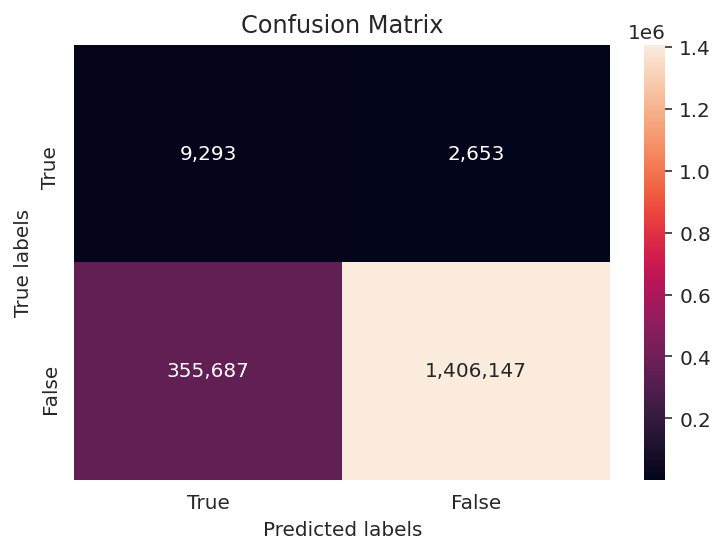

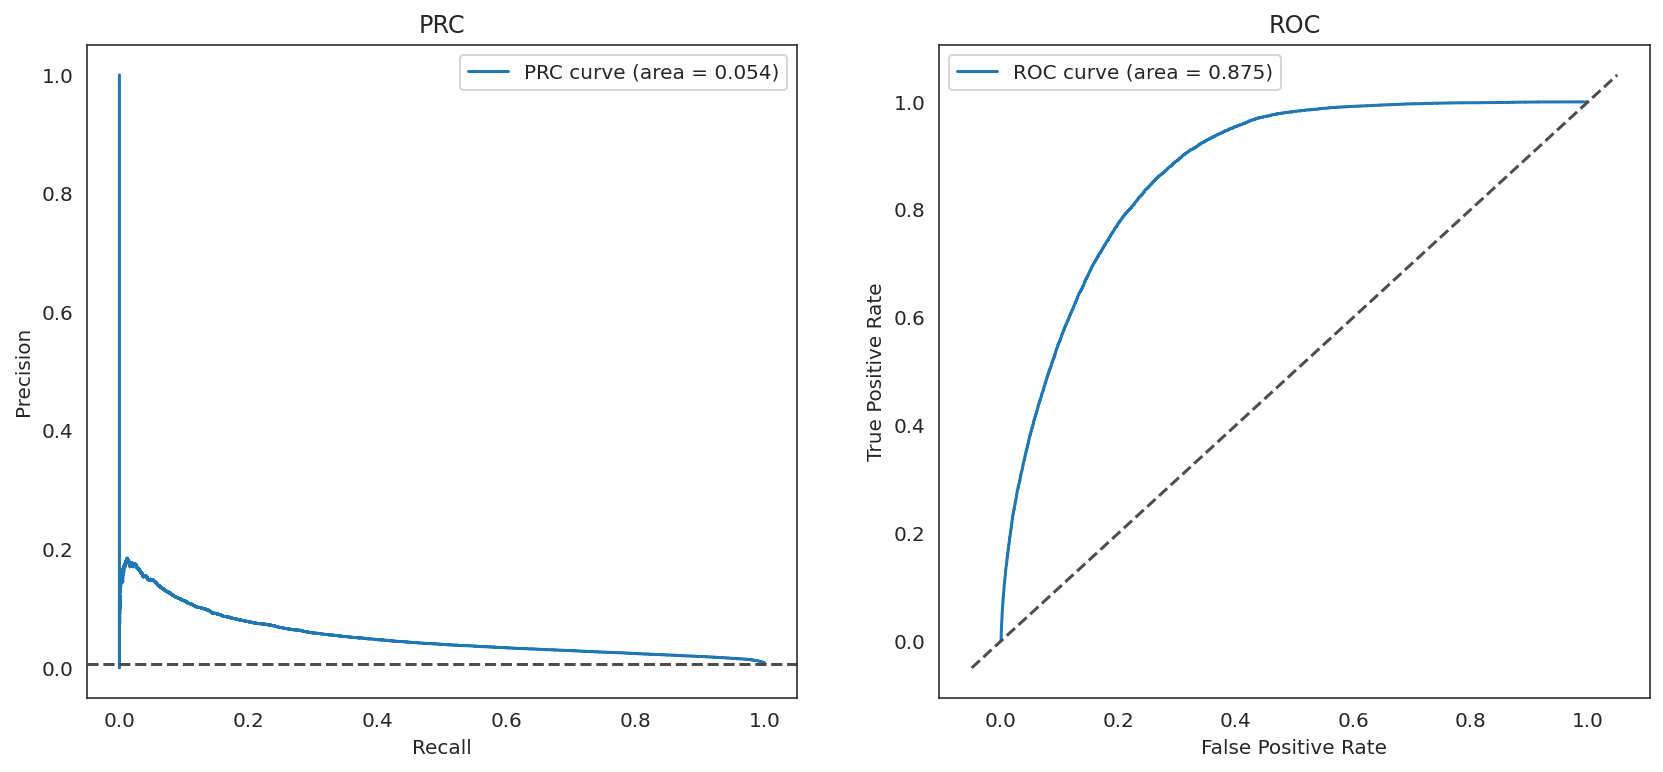

03_frozen_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.037
Accuracy: 0.702
MCC: 0.098
Recall: 0.847
FPR: 0.299




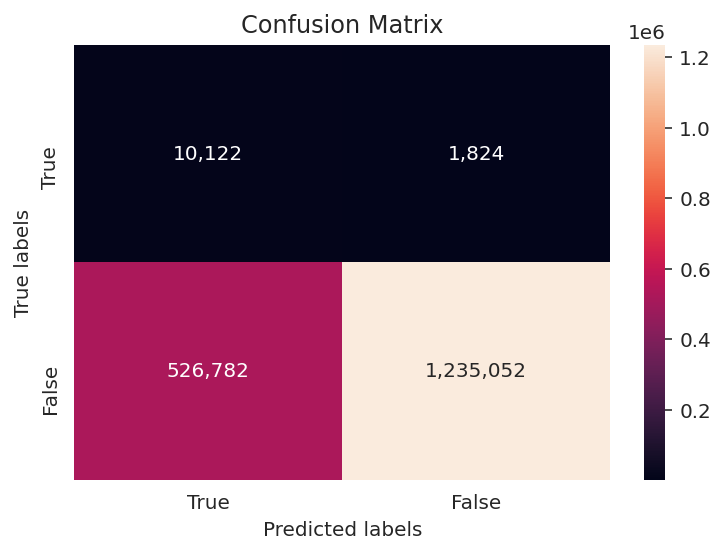

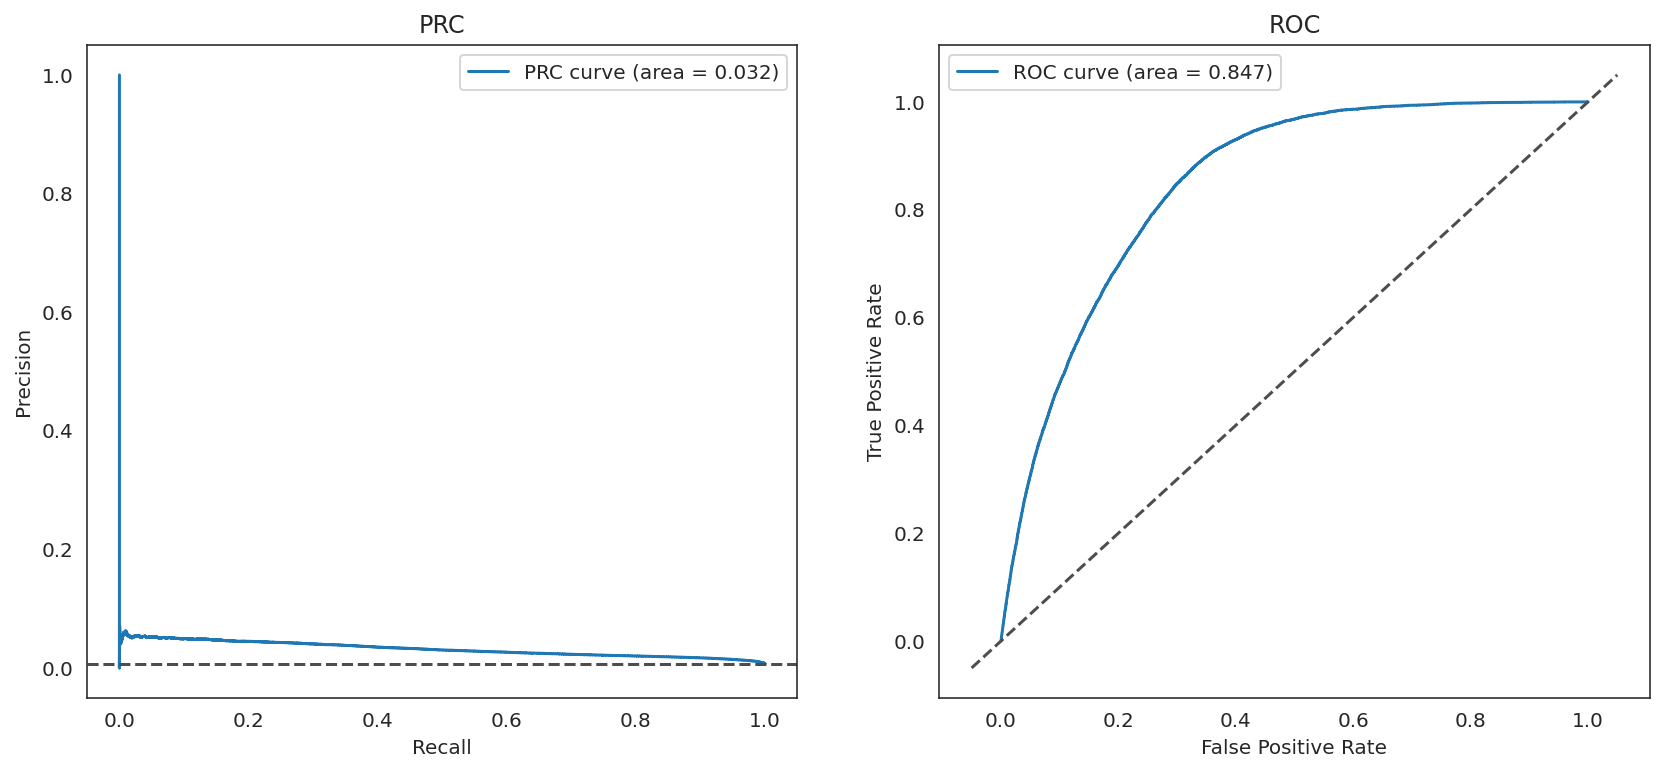

In [8]:
eval_models(y_valid, 'valid_heavy', heavy_models)

### Heavy - weighted

02_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.116
Accuracy: 0.740
MCC: 0.167
Recall: 0.760
FPR: 0.260




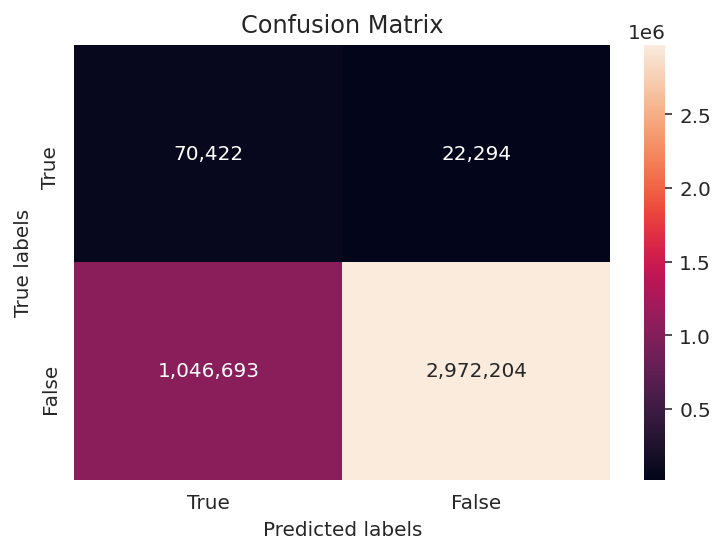

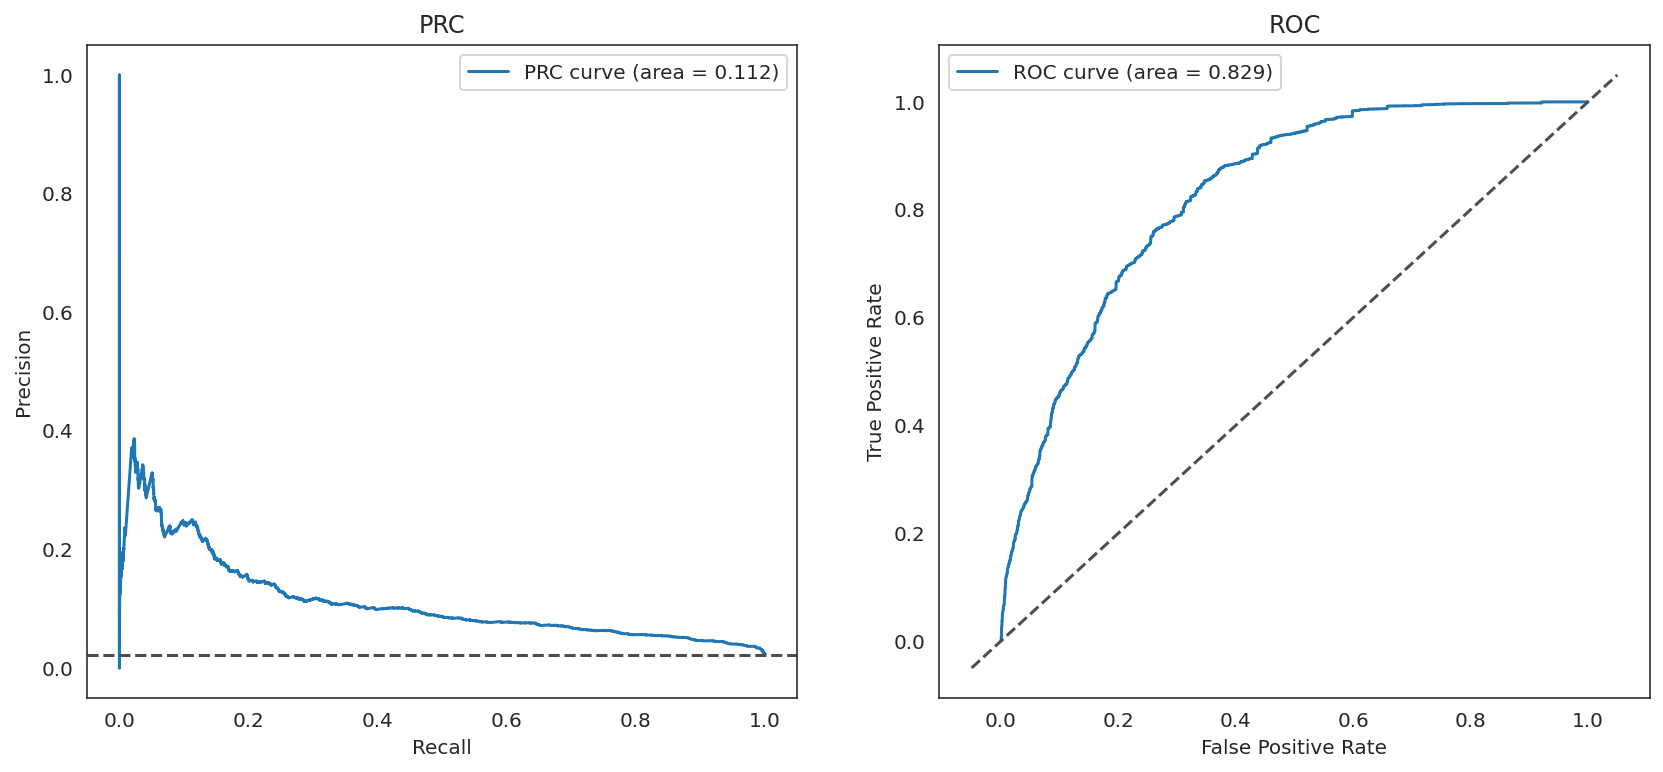

03_frozen_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.088
Accuracy: 0.612
MCC: 0.131
Recall: 0.825
FPR: 0.393




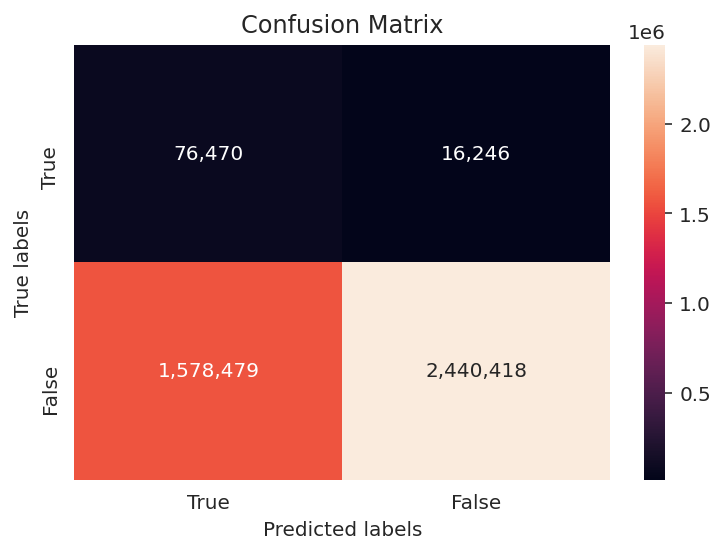

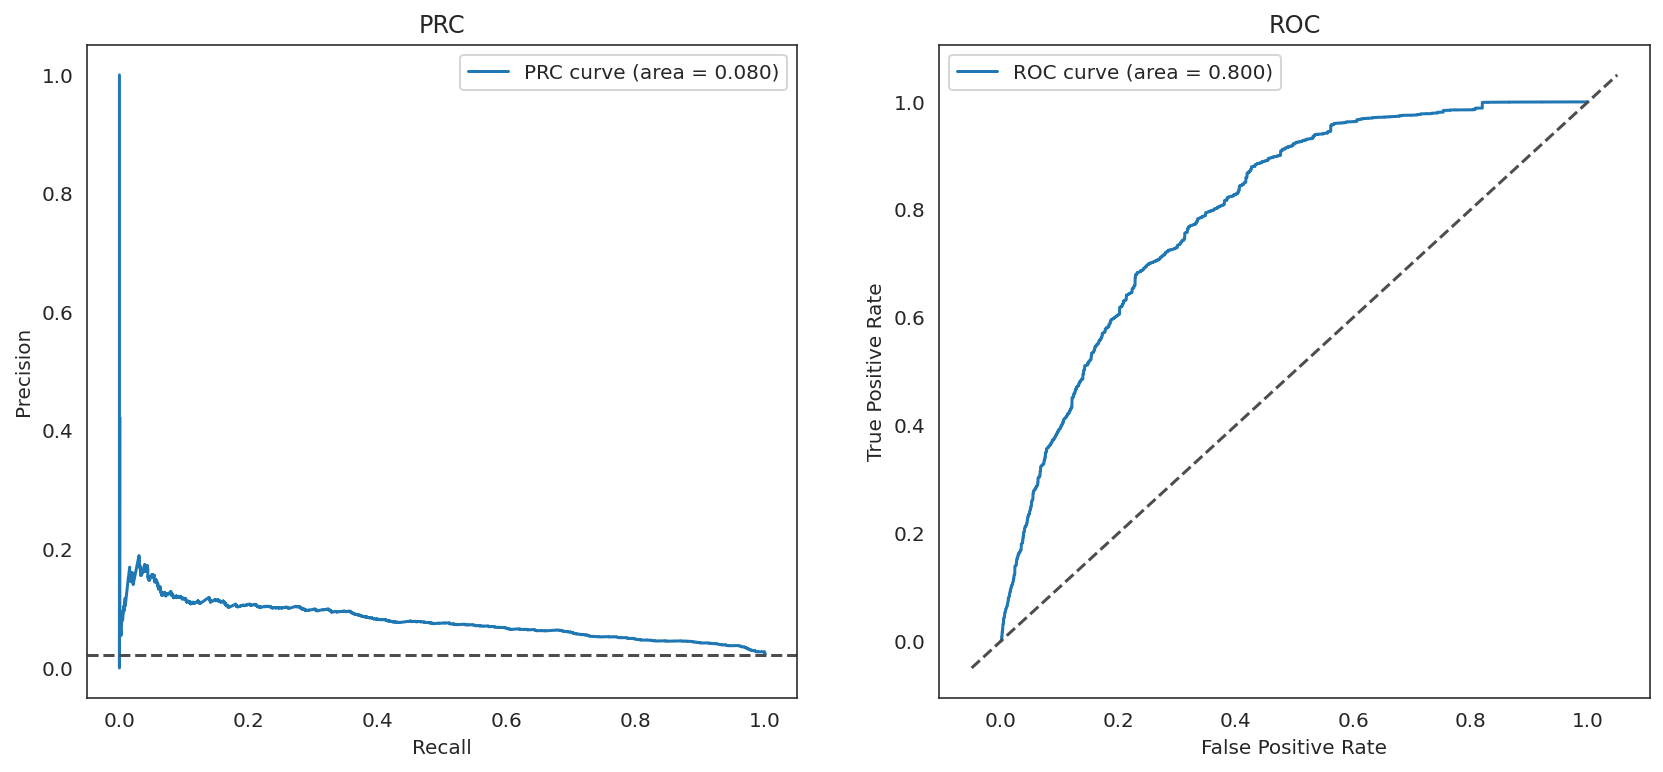

In [9]:
eval_models(y_valid, 'valid_heavy', heavy_models, sample_weights=valid_cluster_sizes)

### CDR3 - non-weighted

In [10]:
cdr3_models = models_from_dir('../../models/RoBERTa/mode_seq/subject_split_neg_subs/')
cdr3_models

['02_small_pretrained_2000epochs', '03_frozen_small_pretrained_2000epochs']

02_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.034
Accuracy: 0.725
MCC: 0.080
Recall: 0.710
FPR: 0.274




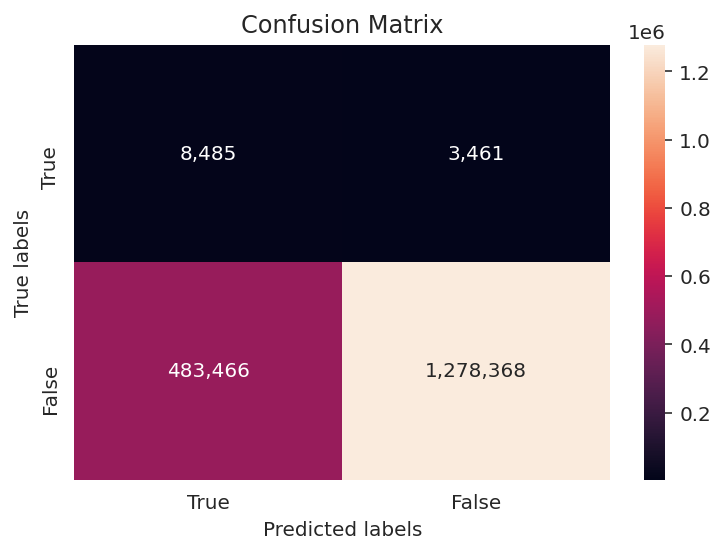

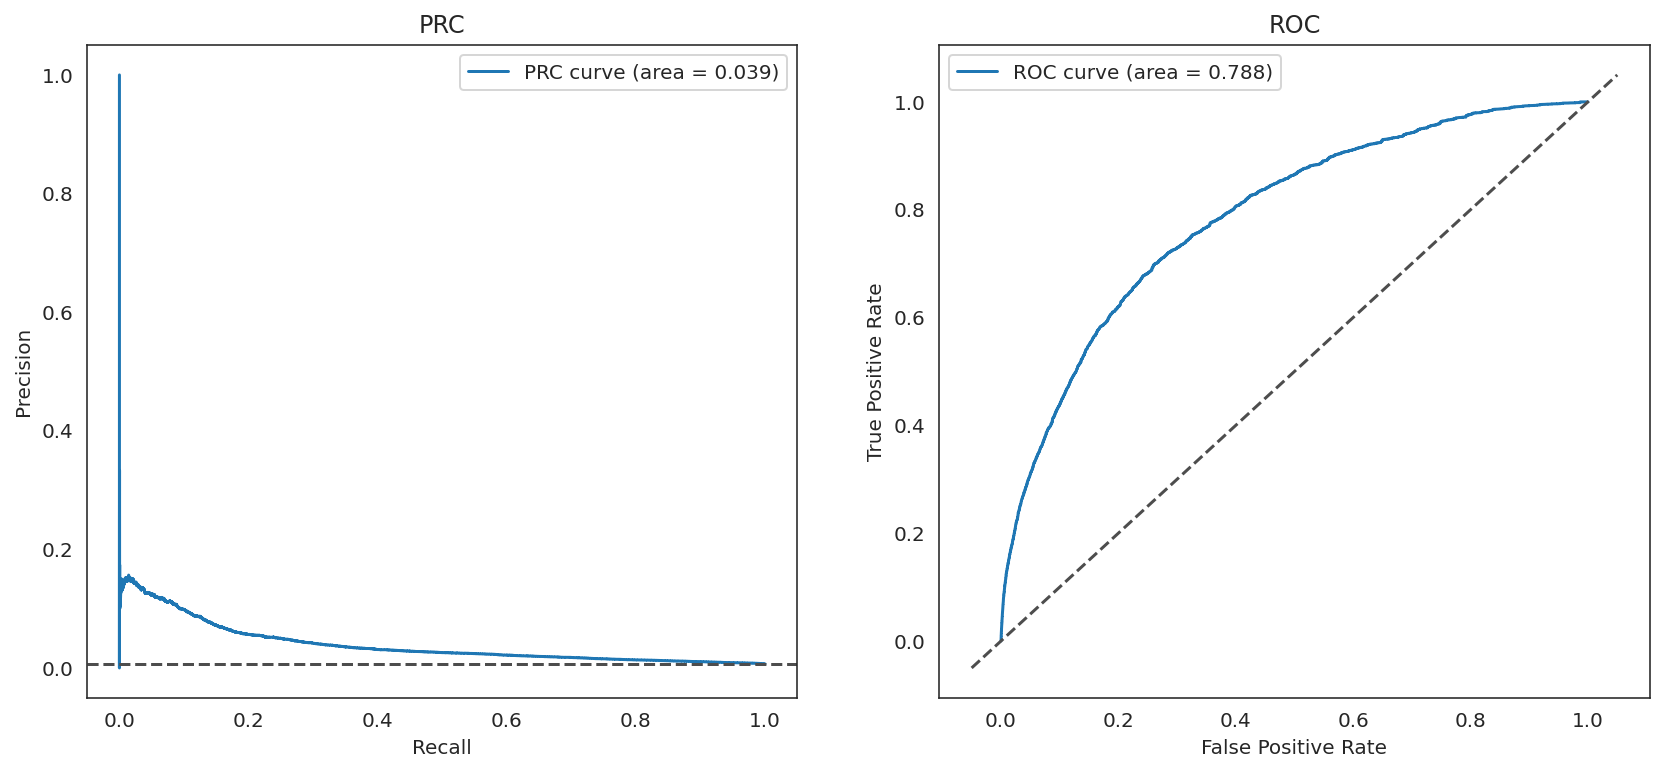

03_frozen_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.030
Accuracy: 0.680
MCC: 0.071
Recall: 0.728
FPR: 0.321




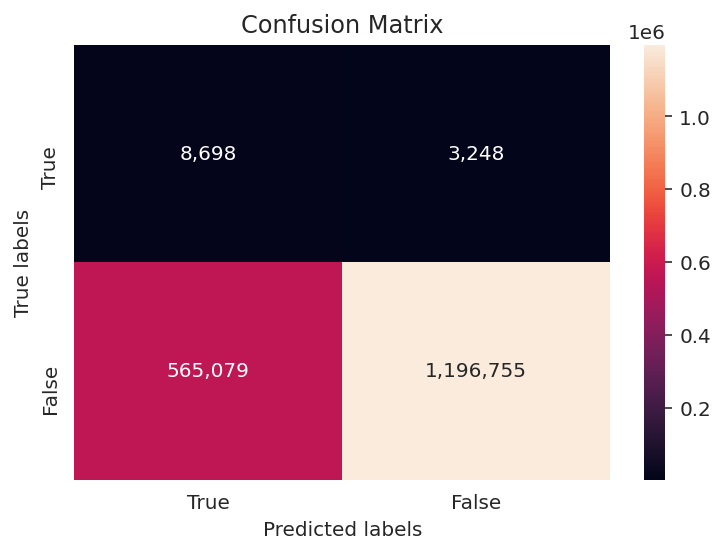

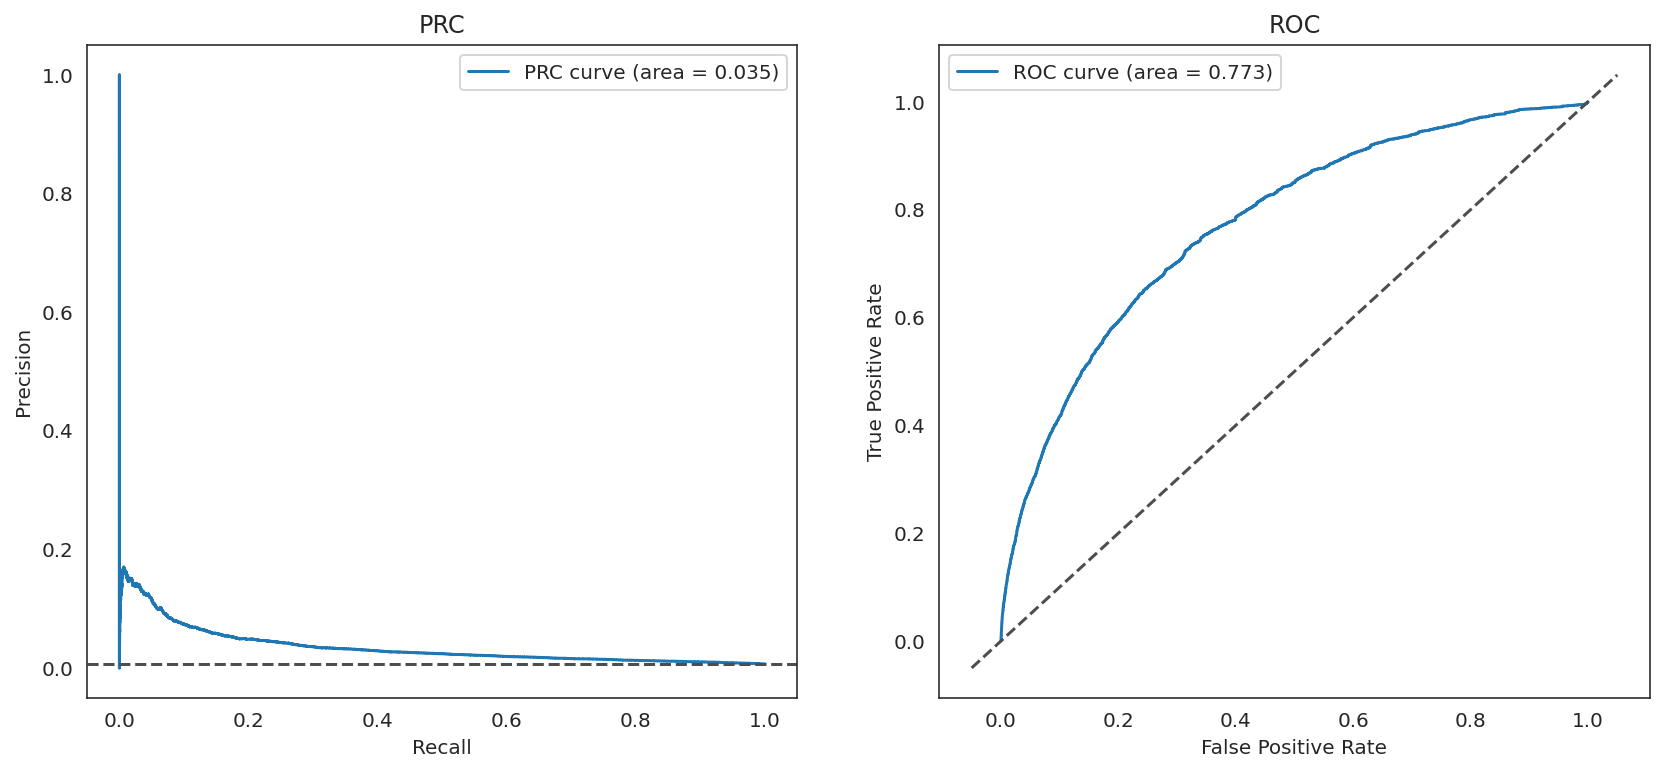

In [11]:
eval_models(y_valid, 'valid_cdr3', cdr3_models)

### CDR3 - weighted

02_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.083
Accuracy: 0.675
MCC: 0.103
Recall: 0.650
FPR: 0.324




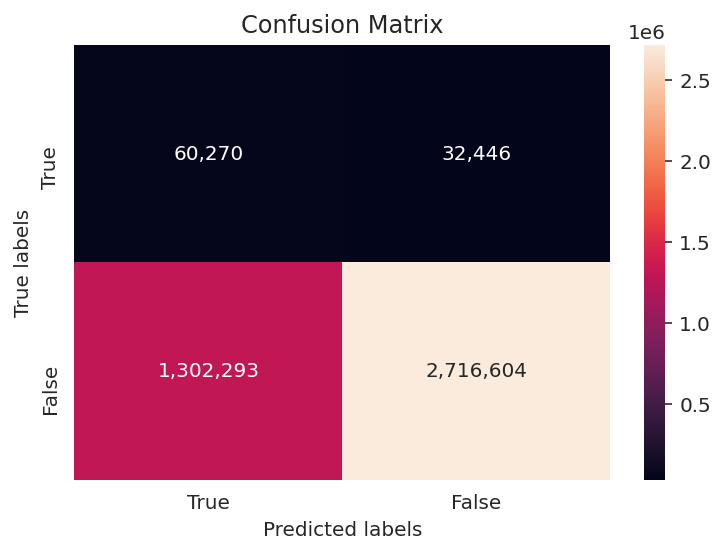

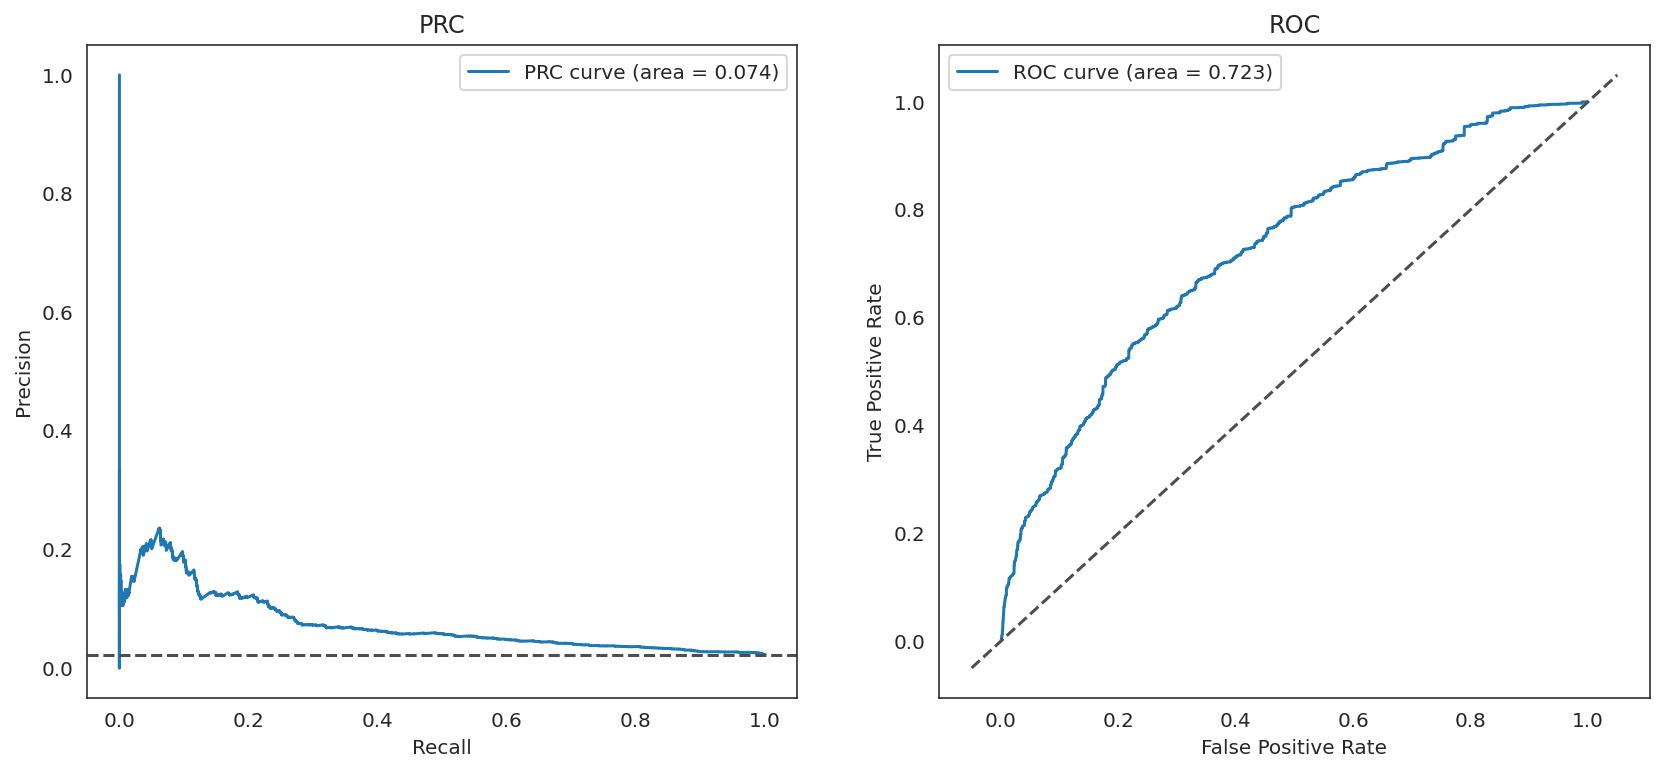

03_frozen_small_pretrained_2000epochs
----------------------------------------
Metric values:

F1: 0.080
Accuracy: 0.636
MCC: 0.102
Recall: 0.698
FPR: 0.365




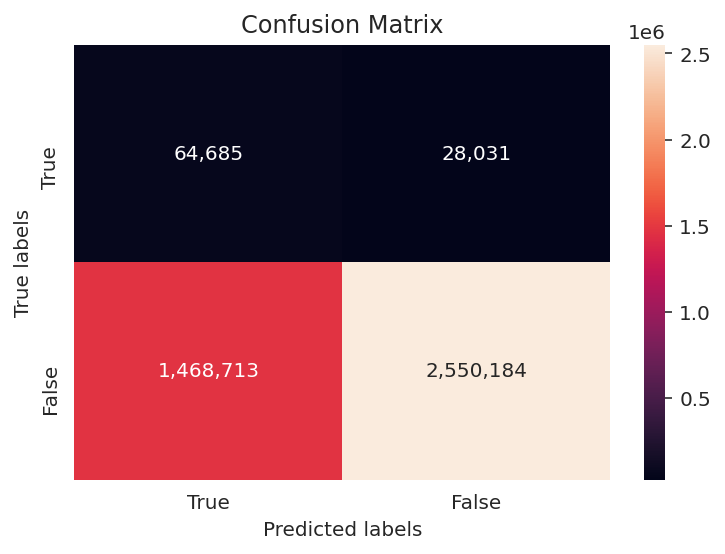

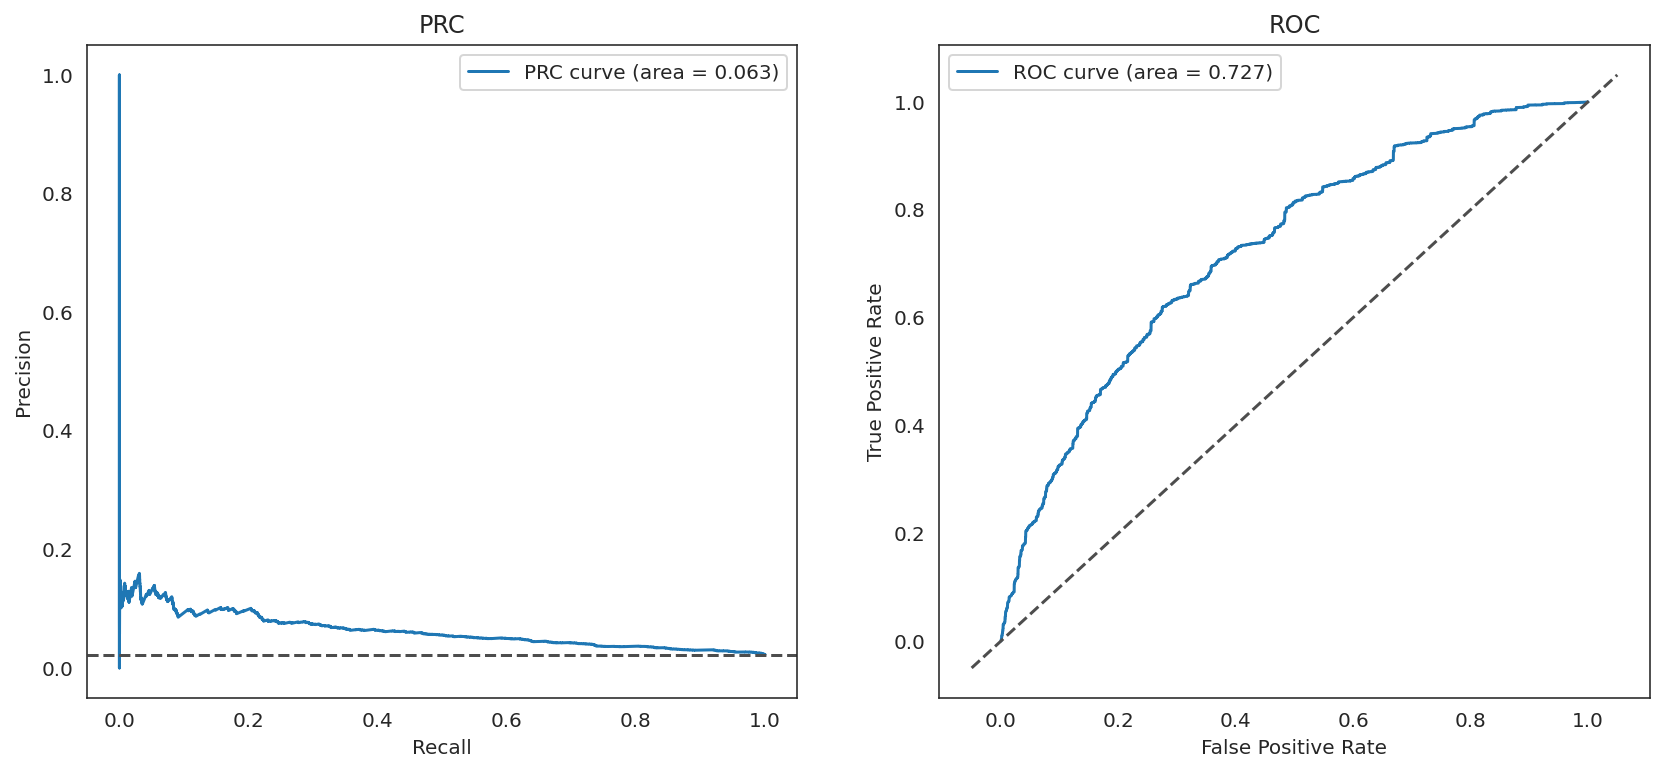

In [12]:
eval_models(y_valid, 'valid_cdr3', cdr3_models, sample_weights=valid_cluster_sizes)